In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pathlib
import random

#tf.enable_eager_execution()

In [2]:
#data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
#                                  fname='flower_photos', untar=True)
data_dir = pathlib.Path('/home/esdl/.keras/datasets/flower_photos')

label_names={'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}
label_key=['daisy','dandelion','roses','sunflowers','tulips']

In [3]:
all_images = list(data_dir.glob('*/*'))
all_images = [str(path) for path in all_images]
random.shuffle(all_images)
 
all_labels=[label_names[pathlib.Path(path).parent.name] for path in all_images]
 
data_size=len(all_images)

train_test_split=(int)(data_size*0.2)

x_train=all_images[train_test_split:]
x_test=all_images[:train_test_split]

y_train=all_labels[train_test_split:]
y_test=all_labels[:train_test_split]

IMG_SIZE=160

BATCH_SIZE = 32

def _parse_data(x,y):
    image = tf.read_file(x)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    #image = (image/127.5) - 1 # -1 ~ 1
    image = (image/255.0) # 0 ~ 1
    image = tf.image.resize_images(image, (IMG_SIZE, IMG_SIZE))
    
    return image,y

def _input_fn(x,y):
    ds=tf.data.Dataset.from_tensor_slices((x,y))
    ds=ds.map(_parse_data)
    ds=ds.shuffle(buffer_size=data_size)
    
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=1)
    return ds
  
train_ds=_input_fn(x_train,y_train)
validation_ds=_input_fn(x_test,y_test)

In [4]:
vgg_model = tf.keras.applications.VGG16(weights = 'imagenet',
                                        include_top = False,
                                        input_shape=(IMG_SIZE, IMG_SIZE, 3))
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0         
__________

In [9]:
#vgg_model.trainable=False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(label_names),activation='softmax')

In [10]:
model = tf.keras.Sequential([
  vgg_model,
  global_average_layer,
  prediction_layer
])

In [11]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [12]:
history = model.fit(train_ds,
                    epochs=100, 
                    steps_per_epoch=2,
                    validation_steps=2,
                    validation_data=validation_ds)

Epoch 1/100
2/2 [==============================] - 10s 5s/step - loss: 4.4271 - acc: 0.2500 - val_loss: 11.5622 - val_acc: 0.2812
Epoch 2/100
2/2 [==============================] - 0s 123ms/step - loss: 12.5892 - acc: 0.2188 - val_loss: 12.8441 - val_acc: 0.2031
Epoch 3/100
2/2 [==============================] - 0s 122ms/step - loss: 12.3404 - acc: 0.2344 - val_loss: 13.5996 - val_acc: 0.1562
Epoch 4/100
2/2 [==============================] - 0s 122ms/step - loss: 12.0886 - acc: 0.2500 - val_loss: 12.8441 - val_acc: 0.2031
Epoch 5/100
2/2 [==============================] - 0s 122ms/step - loss: 12.3404 - acc: 0.2344 - val_loss: 14.3552 - val_acc: 0.1094
Epoch 6/100
2/2 [==============================] - 0s 121ms/step - loss: 12.0886 - acc: 0.2500 - val_loss: 13.3478 - val_acc: 0.1719
Epoch 7/100
2/2 [==============================] - 0s 122ms/step - loss: 12.5923 - acc: 0.2188 - val_loss: 12.5923 - val_acc: 0.2188
Epoch 8/100
2/2 [==============================] - 0s 122ms/step - loss:

In [ ]:
#vgg_model.layers.pop()
#vgg_model.outputs = [vgg_model.layers[-1].output]

In [ ]:
#last = vgg_model.outputs[0]
x = vgg_model.layers[-6].output
x = tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
preds = tf.keras.layers.Dense(len(label_names), activation='softmax')(x)

In [ ]:
model = tf.keras.models.Model(inputs=vgg_model.input, outputs=preds)

In [ ]:
model.summary()

In [ ]:
#vgg_model.trainable=False

In [5]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(label_names),activation='softmax')

model = tf.keras.Sequential([
    vgg_model,
    #tf.keras.layers.ZeroPadding2D(padding=(1, 1)),
    #tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation='relu'),
    #tf.keras.layers.GlobalAveragePooling2D(),
    #tf.keras.layers.Dense(len(label_names), activation='softmax')
    global_average_layer,
    prediction_layer
])

# 왜 인지 모르겠지만 sequential 로 하면 vgg 모델과 sequential 모델이 겹친다고???
# 출처 : https://stackoverflow.com/questions/55466320/grad-cam-visualization-invalid-argument-error-you-must-feed-a-value-for-placeh

In [6]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [6]:
history = model.fit(train_ds,
                    epochs=100, 
                    steps_per_epoch=2,
                    validation_steps=2,
                    validation_data=validation_ds)

Epoch 1/100
2/2 [==============================] - 10s 5s/step - loss: 4.8200 - acc: 0.2344 - val_loss: 12.5923 - val_acc: 0.2188
Epoch 2/100
2/2 [==============================] - 0s 124ms/step - loss: 13.3478 - acc: 0.1719 - val_loss: 12.8441 - val_acc: 0.2031
Epoch 3/100
2/2 [==============================] - 0s 123ms/step - loss: 13.5996 - acc: 0.1562 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 4/100
2/2 [==============================] - 0s 123ms/step - loss: 12.3404 - acc: 0.2344 - val_loss: 12.8441 - val_acc: 0.2031
Epoch 5/100
2/2 [==============================] - 0s 123ms/step - loss: 12.3404 - acc: 0.2344 - val_loss: 11.0812 - val_acc: 0.3125
Epoch 6/100
2/2 [==============================] - 0s 123ms/step - loss: 12.5923 - acc: 0.2188 - val_loss: 12.3404 - val_acc: 0.2344
Epoch 7/100
2/2 [==============================] - 0s 123ms/step - loss: 12.0886 - acc: 0.2500 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 8/100
2/2 [==============================] - 0s 123ms/step - loss:

In [8]:
validation_steps = 20
 
loss0,accuracy0 = model.evaluate(validation_ds, steps = validation_steps)
 
print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 2s 98ms/step
loss: 12.21
accuracy: 0.24


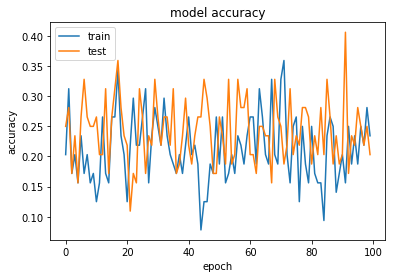

In [9]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

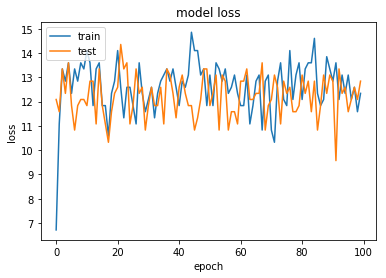

In [10]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from PIL import Image

what = 2

img = Image.open(x_test[what]).resize((160, 160))
img_arr = np.asarray(img)[:, :, :3] / 255
img_array = np.expand_dims(img_arr, 0)


get_output = tf.keras.backend.function([model.layers[0].input],[model.layers[-3].output, model.layers[-1].output])
[conv_outputs, predictions] = get_output([img_array])
conv_outputs = conv_outputs[0, :, :, :]
class_weights = model.layers[-1].get_weights()[0]
cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
for i, w in enumerate(class_weights[:, y_test[what]]):
    cam += w * conv_outputs[:, :, i]
cam /= np.max(cam)
cam = cv2.resize(cam, (160, 160))

plt.subplot(1,2,1)
plt.imshow(img_arr)
plt.subplot(1,2,2)
plt.imshow(cam)

# Another example

In [5]:
#vgg_model.trainable=False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(label_names),activation='softmax')

In [6]:
model = tf.keras.Sequential([
  vgg_model,
  global_average_layer,
  prediction_layer
])

In [7]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [8]:
history = model.fit(train_ds,
                    epochs=100, 
                    steps_per_epoch=2,
                    validation_steps=2,
                    validation_data=validation_ds)

Epoch 1/100
2/2 [==============================] - 10s 5s/step - loss: 7.7804 - acc: 0.1719 - val_loss: 14.6070 - val_acc: 0.0938
Epoch 2/100
2/2 [==============================] - 0s 125ms/step - loss: 14.8589 - acc: 0.0781 - val_loss: 14.1033 - val_acc: 0.1250
Epoch 3/100
2/2 [==============================] - 0s 123ms/step - loss: 13.8515 - acc: 0.1406 - val_loss: 12.8441 - val_acc: 0.2031
Epoch 4/100
2/2 [==============================] - 0s 123ms/step - loss: 14.3552 - acc: 0.1094 - val_loss: 13.8515 - val_acc: 0.1406
Epoch 5/100
2/2 [==============================] - 0s 123ms/step - loss: 13.0960 - acc: 0.1875 - val_loss: 11.8367 - val_acc: 0.2656
Epoch 6/100
2/2 [==============================] - 0s 123ms/step - loss: 13.3478 - acc: 0.1719 - val_loss: 13.5996 - val_acc: 0.1562
Epoch 7/100
2/2 [==============================] - 0s 124ms/step - loss: 14.1033 - acc: 0.1250 - val_loss: 12.0886 - val_acc: 0.2500
Epoch 8/100
2/2 [==============================] - 0s 123ms/step - loss:

In [9]:
validation_steps = 20
 
loss0,accuracy0 = model.evaluate(validation_ds, steps = validation_steps)
 
print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 2s 113ms/step
loss: 13.15
accuracy: 0.18


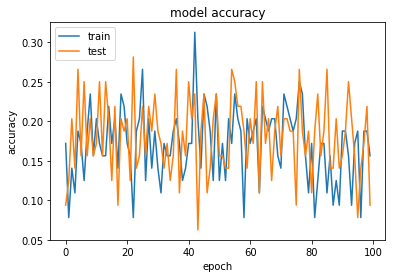

In [10]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

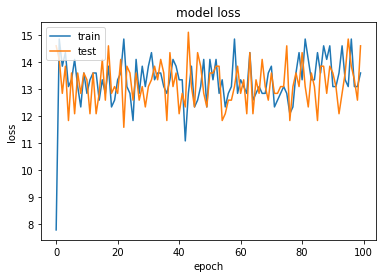

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.summary()

In [ ]:
from PIL import Image

what = 2

img = Image.open(x_test[what]).resize((160, 160))
img_arr = np.asarray(img)[:, :, :3] / 255
img_array = np.expand_dims(img_arr, 0)


get_output = tf.keras.backend.function([model.layers[0].input],[model.layers[-3].output, model.layers[-1].output])
[conv_outputs, predictions] = get_output([img_array])
conv_outputs = conv_outputs[0, :, :, :]
class_weights = model.layers[-1].get_weights()[0]
cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
for i, w in enumerate(class_weights[:, y_test[what]]):
    cam += w * conv_outputs[:, :, i]
cam /= np.max(cam)
cam = cv2.resize(cam, (160, 160))

plt.subplot(1,2,1)
plt.imshow(img_arr)
plt.subplot(1,2,2)
plt.imshow(cam)